In [25]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split,Dataset
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.datasets import VOCSegmentation
from PIL import Image
import os
import cv2

#iuo
import torch.nn.functional as F
from sklearn.metrics import jaccard_score

# Data load

In [26]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.png')] #jpg or png etc.
        self.mask_filenames = [f for f in os.listdir(mask_dir) if f.endswith('.png')]
        

        assert len(self.image_filenames) == len(self.mask_filenames), "Image and mask counts do not match"

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_name = os.path.join(self.mask_dir, self.mask_filenames[idx])
        
        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name).convert('L')  # 'L' grayscale mask
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask


# train test & visulaziton 

In [27]:
# Data converters
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

# dataset
dataset = CustomDataset(image_dir='DataSet/images', mask_dir='DataSet/masks', transform=transform)


In [28]:
# subset_indices = range(400)
# dataset = torch.utils.data.Subset(dataset, subset_indices)

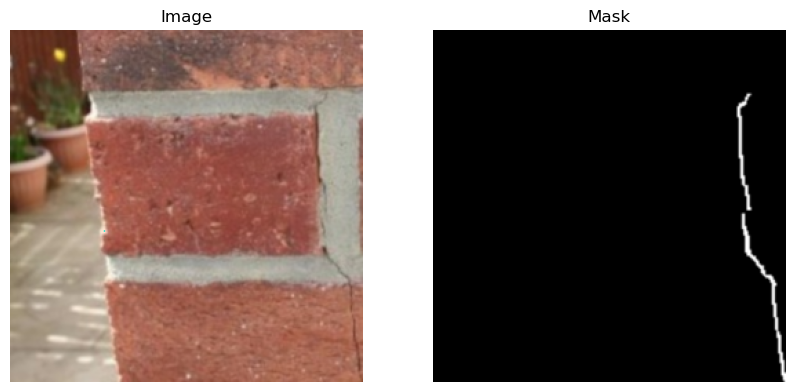

In [29]:
idx =50
image, mask = dataset[idx]

# Convert tensors back to numpy arrays
image = image.numpy().transpose(1, 2, 0)  # CHW to HWC
mask = mask.numpy().squeeze()             # Remove channel dimension

# Denormalize the image (assuming normalization was done)
image = image * 256.0
image = image.astype(np.uint8)

# Plot the image and mask
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image)
axs[0].set_title('Image')
axs[0].axis('off')

axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Mask')
axs[1].axis('off')

plt.show()

In [30]:
# Separate training and testing dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [31]:
# Print dimensions of training and testing dataset
print(f'Total dataset size: {len(dataset)}')
print(f'Training dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

# Print data sample count of data loaders
print(f'Training data loader total number of samples: {len(train_loader.dataset)}')
print(f'Test data loader total number of samples: {len(test_loader.dataset)}')

# Print batch number in training and test data loaders
print(f'Total batch number of training data loader: {len(train_loader)}')
print(f'Test data loader total batch number: {len(test_loader)}')

# Print a sample batch size (from the training data loader)
for images, masks in train_loader:
 print(f'Size of a training batch - Image: {images.size()}, Mask: {masks.size()}')
 break # check first batch only

Total dataset size: 9159
Training dataset size: 7327
Test dataset size: 1832
Training data loader total number of samples: 7327
Test data loader total number of samples: 1832
Total batch number of training data loader: 1832
Test data loader total batch number: 458
Size of a training batch - Image: torch.Size([4, 3, 256, 256]), Mask: torch.Size([4, 1, 256, 256])


In [32]:
import torch
from torch.utils.data import DataLoader, Subset
import numpy as np

# Get indexes of test dataset
test_indices = np.arange(len(test_dataset))

# Select 5 random indexes
random_indices = np.random.choice(test_indices, size=5, replace=False)

# Create subset
ran_test_subset = Subset(test_dataset, random_indices)

# Create DataLoader
ran_test_loader = DataLoader(ran_test_subset, batch_size=1, shuffle=False)

# Sample data output
for images, masks in ran_test_loader:
    print(f"Images batch shape: {images.shape}")
    print(f"Masks batch shape: {masks.shape}")
    break  # Show only the first example

Images batch shape: torch.Size([1, 3, 256, 256])
Masks batch shape: torch.Size([1, 1, 256, 256])


# criterion ve deeplab- modeli yükleme

In [33]:
from torchvision.models.segmentation import deeplabv3_resnet50

# Create the model and take it to training
model_deeplab = deeplabv3_resnet50(pretrained=False, num_classes=1)
model_deeplab.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=1)  # Single channel (grayscale)

criterion= torch.nn.BCEWithLogitsLoss()  # Binary Cross-Entropy for binary segmentation
optimizer_deeplab = torch.optim.Adam(model_deeplab.parameters(), lr=1e-4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_deeplab.to(device)


C:\Users\ilker\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ilker\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

# UnetPlusPlus 

In [34]:
from segmentation_models_pytorch import UnetPlusPlus

model_unetpp = UnetPlusPlus(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1)

optimizer_unetpp = torch.optim.Adam(model_unetpp.parameters(), lr=1e-4)
model_unetpp.to(device)


UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

# Unet

In [35]:
from segmentation_models_pytorch import Unet

# Create the UNet model
model_unet = Unet(
    encoder_name="resnet34",       # Encoder type
    encoder_weights="imagenet",    # Encoder weights pre-trained with ImageNet
    in_channels=3,                 # Number of channels in the input image (e.g. 3 for RGB)
    classes=1                      # Number of output channels (1 for segmentation mask)
)
# Set the model to run on the device
model_unet = model_unet.to(device)

# Define the optimizer
optimizer_unet = torch.optim.Adam(model_unet.parameters(), lr=1e-4)

# UsquareNet

In [36]:
!git clone https://github.com/xuebinqin/U-2-Net.git

fatal: destination path 'U-2-Net' already exists and is not an empty directory.


In [37]:
#print(os.listdir('U-2-Net'))
#print(os.listdir('U-2-Net/model'))
#with open('U-2-Net/model/u2net.py', 'r') as file:
   # print(file.read())

In [38]:
import sys
sys.path.append(os.path.join(os.getcwd(), 'U-2-Net'))
from model.u2net import U2NET # File containing the U2Net model
# Create the model and set it to run on the device
model_u2net = U2NET(3, 1)  # 3 channels RGB and 1 channel output
optimizer_u2net = torch.optim.Adam(model_u2net.parameters(), lr=1e-4)

model_u2net.to(device)

U2NET(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(32, 32, k

# SegNet

In [39]:
!git clone https://github.com/delta-onera/segnet_pytorch


fatal: destination path 'segnet_pytorch' already exists and is not an empty directory.


In [40]:
from segnet_pytorch.segnet import SegNet

In [41]:
model_segnet = SegNet(input_nbr=3, label_nbr=1) #1 can be adjusted according to the number of classes
model_segnet.to(device)
optimizer_segnet = torch.optim.Adam(model_segnet.parameters(), lr=1e-4)

# IoU Metric

In [42]:
def iou_metric(pred, target, threshold=0.5):
    # Apply sigmoid to model outputs to get probabilities
    pred = torch.sigmoid(pred)
    
    # Apply threshold to get binary predictions
    pred = (pred > threshold).float()
    
    # Invert target if necessary (0 -> background, 1 -> object)
    target = 1 - target
    
    # Compute intersection and union
    intersection = (pred * target).sum()
    union = (pred + target).sum() - intersection
    
    if union == 0:
        return float('nan')  # Handle edge case when union is zero
    
    iou = intersection / (union + 1e-6)  # Adding epsilon to avoid division by zero
    return iou.item()

# Model save

In [43]:
# Create a folder called 'models', don't create it if it exists
os.makedirs('models', exist_ok=True)

# eğitme ve görüntüleme

In [44]:
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs, is_deeplab=False):
    model.train()
    print("Starting Net...")
    train_losses = []
    test_losses = []
    test_ious = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_iou = 0.0
        model.train()
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            
            if is_deeplab:
                outputs = outputs['out']

            if isinstance(outputs, tuple):
                primary_output = outputs[0]
            else:
                primary_output = outputs
            
            loss = criterion(primary_output.squeeze(1), masks.squeeze(1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()
        test_loss = 0.0
        test_iou = 0.0
        with torch.no_grad():
            for images, masks in test_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                if is_deeplab:
                    outputs = outputs['out']
                
                if isinstance(outputs, tuple):
                    primary_output = outputs[0]
                else:
                    primary_output = outputs
                
                loss = criterion(primary_output.squeeze(1), masks.squeeze(1))
                test_loss += loss.item() * images.size(0)
                iou = iou_metric(primary_output.squeeze(1), masks)
                test_iou += iou * images.size(0)

        test_loss /= len(test_loader.dataset)
        test_iou /= len(test_loader.dataset)

        test_losses.append(test_loss)
        test_ious.append(test_iou)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}')

    # Save model
    model_name = f'{model.__class__.__name__}.pth'
    save_path = os.path.join('models', model_name)
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to {save_path}')
    
    return train_losses, test_losses, test_ious


In [45]:

# # Train and visualize each model

# models = {
#     'DeeplabV3': (model_deeplab, optimizer_deeplab, True),
#     'UNet++': (model_unetpp, optimizer_unetpp, False),
#     'UNet': (model_unet, optimizer_unet, False),
#     'U2Net': (model_u2net, optimizer_u2net, False),
#     'SegNet': (model_segnet, optimizer_segnet, False)
# }

# results = {}
#example this format
# for model_name, (model, optimizer, is_deeplab) in models.items():
#     print(f'Training {model_name}')
#     train_losses, test_losses, test_ious = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=5, is_deeplab=is_deeplab)
#     results[model_name] = (train_losses, test_losses, test_ious)

#     # Visualize results
#     # visualize_results(model, ran_test_loader, is_deeplab=is_deeplab)

# Plotting function
# def plot_metrics(metrics, metric_name):
#     plt.figure(figsize=(10, 5))
#     for model_name, values in metrics.items():
#         plt.plot(values, label=model_name)
#     plt.xlabel('Epoch')
#     plt.ylabel(metric_name)
#     plt.title(f'{metric_name} per Epoch')
#     plt.legend()
#     plt.show()

In [46]:
import matplotlib.pyplot as plt

def visualize_results(model, test_loader, is_deeplab=False):
    model.eval()
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            
            # If Deeplab model, get main output
            if is_deeplab:
                primary_output = outputs['out']
            else:
                primary_output = outputs
            
            # If outputs is a tuple, usually some of the model's output is the main output.
            #for U2Net
            if isinstance(primary_output, tuple):
                primary_output = primary_output[0]
            
            # Take appropriate action
            primary_output = torch.sigmoid(primary_output).squeeze(1)  # (B, 1, H, W) -> (B, H, W)
            masks = masks.squeeze(1)  # (B, 1, H, W) -> (B, H, W)
            
            # calculate IoU
            iou = iou_metric(primary_output, masks)
            print(f'IoU: {iou:.4f}')
            
            # Visualization
            for i in range(1):
                plt.figure(figsize=(15, 5))
                
                plt.subplot(1, 3, 1)
                plt.imshow(images[i].cpu().numpy().transpose(1, 2, 0))  # (B, C, H, W) -> (H, W, C)
                plt.title('Input Image')

                plt.subplot(1, 3, 2)
                plt.imshow(masks[i].cpu().numpy(), cmap='gray')  # (H, W)
                plt.title('Ground Truth')

                plt.subplot(1, 3, 3)
                plt.imshow(primary_output[i].cpu().numpy(), cmap='gray')  # (H, W)
                plt.title('Predicted Mask')

                plt.show()
                break


In [47]:
# Plot the training and validation loss
def plot_loss(train_losses,test_losses,test_ious):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(test_ious, label='IuO')
    plt.xlabel('Epochs')
    plt.ylabel('IuO')
    plt.title('IuO')
    plt.legend()
    plt.show()

# Deeplab 

In [48]:
# Deeplab training and visualization
train_losses, test_losses, test_ious = train_model(model_deeplab, criterion, optimizer_deeplab, train_loader, test_loader, num_epochs=50, is_deeplab=True)

Starting Net...
Epoch [1/50], Loss: 0.0928, Test Loss: 0.0554, Test IoU: 0.0200
Epoch [2/50], Loss: 0.0521, Test Loss: 0.0501, Test IoU: 0.0166
Epoch [3/50], Loss: 0.0471, Test Loss: 0.0477, Test IoU: 0.0175
Epoch [4/50], Loss: 0.0440, Test Loss: 0.0472, Test IoU: 0.0164
Epoch [5/50], Loss: 0.0414, Test Loss: 0.0466, Test IoU: 0.0228
Epoch [6/50], Loss: 0.0392, Test Loss: 0.0449, Test IoU: 0.0212
Epoch [7/50], Loss: 0.0388, Test Loss: 0.0451, Test IoU: 0.0204
Epoch [8/50], Loss: 0.0367, Test Loss: 0.0454, Test IoU: 0.0210
Epoch [9/50], Loss: 0.0351, Test Loss: 0.0450, Test IoU: 0.0214
Epoch [10/50], Loss: 0.0335, Test Loss: 0.0463, Test IoU: 0.0221
Epoch [11/50], Loss: 0.0328, Test Loss: 0.0452, Test IoU: 0.0219
Epoch [12/50], Loss: 0.0316, Test Loss: 0.0451, Test IoU: 0.0238
Epoch [13/50], Loss: 0.0309, Test Loss: 0.0473, Test IoU: 0.0228
Epoch [14/50], Loss: 0.0295, Test Loss: 0.0490, Test IoU: 0.0262
Epoch [15/50], Loss: 0.0294, Test Loss: 0.0469, Test IoU: 0.0233
Epoch [16/50], Los

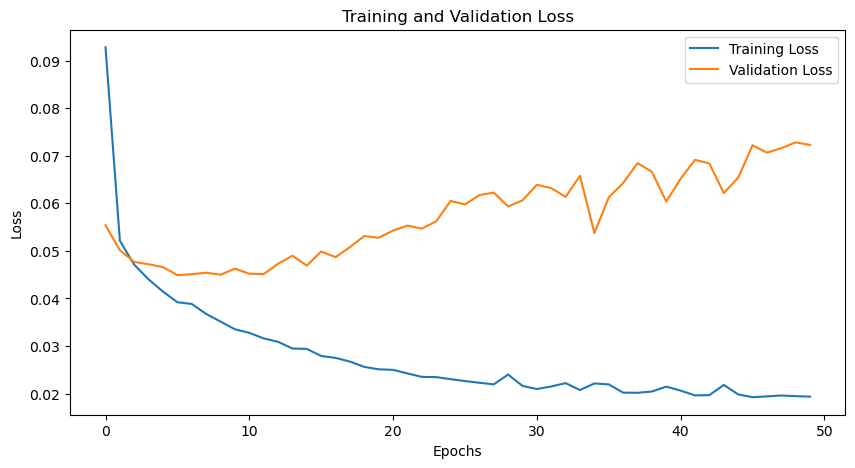

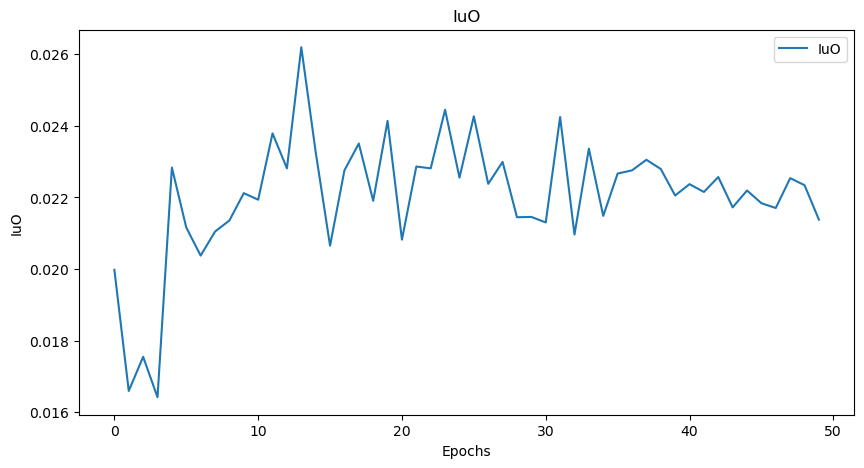

In [49]:
plot_loss(train_losses,test_losses,test_ious)

IoU: 0.2015


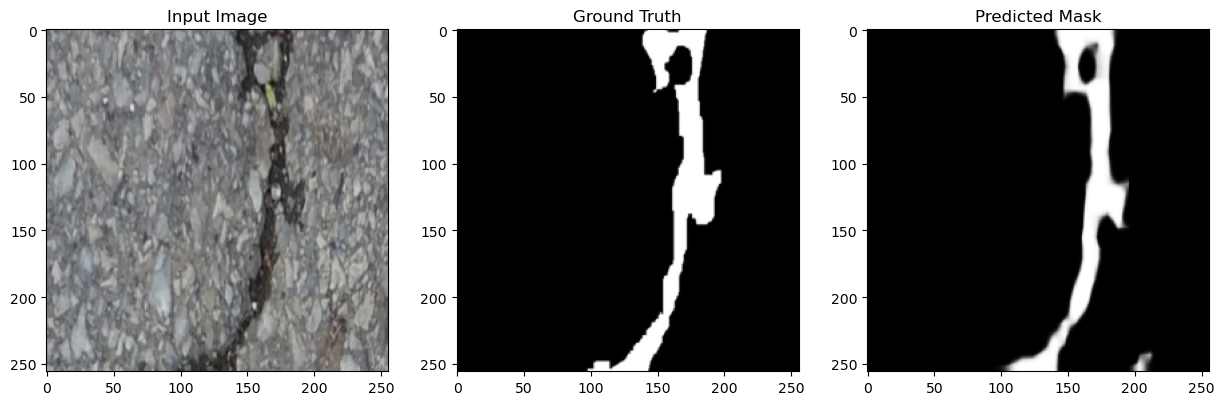

IoU: 0.1838


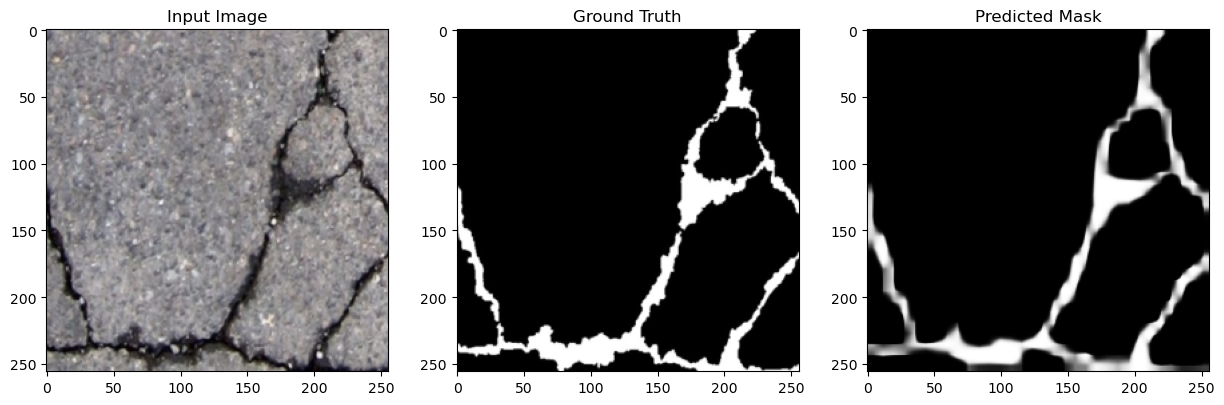

IoU: 0.1062


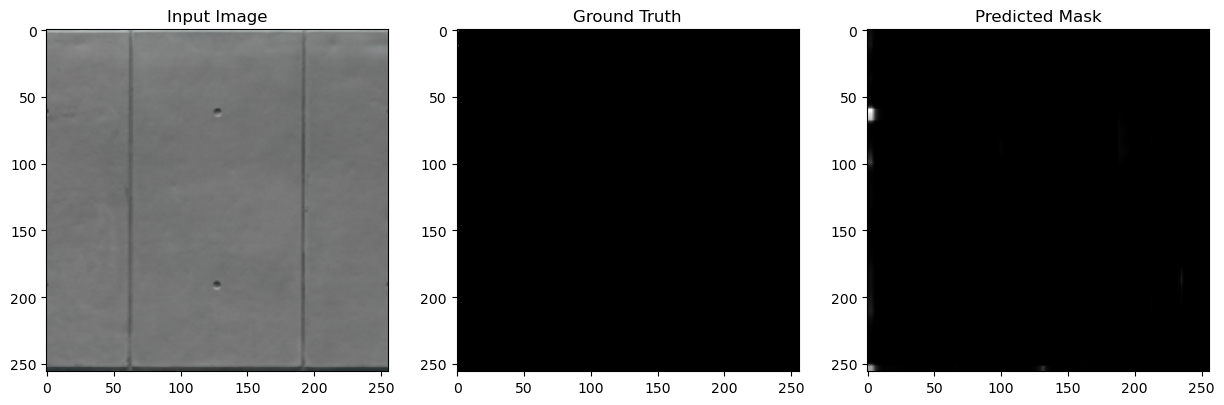

IoU: 0.1473


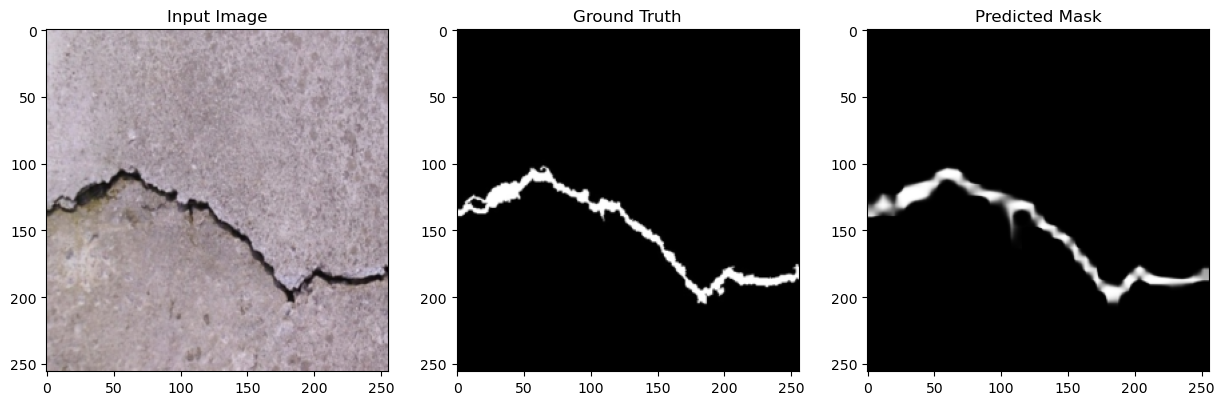

IoU: 0.2153


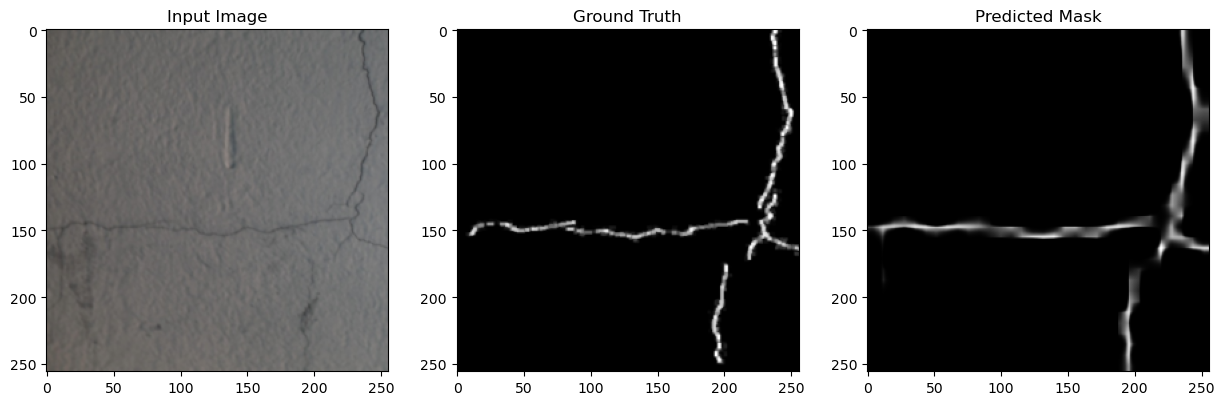

In [50]:
# Sonuçları görselleştir
visualize_results(model_deeplab, ran_test_loader,is_deeplab=True)

# unetpp 

In [ ]:
train_losses, test_losses, test_ious = train_model(model_unetpp, criterion, optimizer_unetpp, train_loader,test_loader, num_epochs=50)

Starting Net...
Epoch [1/50], Loss: 0.1319, Test Loss: 0.0669, Test IoU: 0.0305
Epoch [2/50], Loss: 0.0503, Test Loss: 0.0507, Test IoU: 0.0273
Epoch [3/50], Loss: 0.0448, Test Loss: 0.0453, Test IoU: 0.0196
Epoch [4/50], Loss: 0.0421, Test Loss: 0.0432, Test IoU: 0.0238
Epoch [5/50], Loss: 0.0394, Test Loss: 0.0461, Test IoU: 0.0224
Epoch [6/50], Loss: 0.0369, Test Loss: 0.0430, Test IoU: 0.0229
Epoch [7/50], Loss: 0.0358, Test Loss: 0.0429, Test IoU: 0.0224
Epoch [8/50], Loss: 0.0340, Test Loss: 0.0430, Test IoU: 0.0214
Epoch [9/50], Loss: 0.0326, Test Loss: 0.0450, Test IoU: 0.0205
Epoch [10/50], Loss: 0.0312, Test Loss: 0.0443, Test IoU: 0.0226
Epoch [11/50], Loss: 0.0306, Test Loss: 0.0451, Test IoU: 0.0254
Epoch [12/50], Loss: 0.0287, Test Loss: 0.0468, Test IoU: 0.0213
Epoch [13/50], Loss: 0.0277, Test Loss: 0.0458, Test IoU: 0.0207
Epoch [14/50], Loss: 0.0270, Test Loss: 0.0485, Test IoU: 0.0218


In [ ]:
plot_loss(train_losses,test_losses,test_ious)

In [ ]:
visualize_results(model_unetpp, ran_test_loader)

# Unet

In [ ]:
train_losses, test_losses, test_ious = train_model(model_unet, criterion, optimizer_unet, train_loader,test_loader, num_epochs=50)

In [ ]:
plot_loss(train_losses,test_losses,test_ious)

In [ ]:
visualize_results(model_unetpp, ran_test_loader)

# UsquareNet

In [ ]:
train_losses, test_losses, test_ious = train_model(model_u2net, criterion, optimizer_u2net, train_loader,test_loader, num_epochs=50)

In [ ]:
plot_loss(train_losses,test_losses,test_ious)

In [ ]:
visualize_results(model_u2net, ran_test_loader)

# Segnet

In [ ]:
train_losses, test_losses, test_ious = train_model(model_segnet, criterion, optimizer_segnet,train_loader,test_loader, num_epochs=50)

In [ ]:
plot_loss(train_losses,test_losses,test_ious)

In [ ]:
visualize_results(model_segnet, test_loader)